In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

spark-3.0.1-bin-hadoop3.2/
spark-3.0.1-bin-hadoop3.2/RELEASE
spark-3.0.1-bin-hadoop3.2/examples/
spark-3.0.1-bin-hadoop3.2/examples/src/
spark-3.0.1-bin-hadoop3.2/examples/src/main/
spark-3.0.1-bin-hadoop3.2/examples/src/main/scala/
spark-3.0.1-bin-hadoop3.2/examples/src/main/scala/org/
spark-3.0.1-bin-hadoop3.2/examples/src/main/scala/org/apache/
spark-3.0.1-bin-hadoop3.2/examples/src/main/scala/org/apache/spark/
spark-3.0.1-bin-hadoop3.2/examples/src/main/scala/org/apache/spark/examples/
spark-3.0.1-bin-hadoop3.2/examples/src/main/scala/org/apache/spark/examples/ml/
spark-3.0.1-bin-hadoop3.2/examples/src/main/scala/org/apache/spark/examples/ml/FPGrowthExample.scala
spark-3.0.1-bin-hadoop3.2/examples/src/main/scala/org/apache/spark/examples/ml/GBTExample.scala
spark-3.0.1-bin-hadoop3.2/examples/src/main/scala/org/apache/spark/examples/ml/ALSExample.scala
spark-3.0.1-bin-hadoop3.2/examples/src/main/scala/org/apache/spark/examples/ml/KMeansExample.scala
spark-3.0.1-bin-hadoop3.2/example

Load data from test.csv and train.csv directly from github

In [3]:
import urllib.request
from io import StringIO

testurl = "https://raw.githubusercontent.com/aman1002/McKinseyOnlineHackathon-Healthcare-/master/test.csv"
testresponse = urllib.request.urlopen(testurl)
testdata = testresponse.read()      
testtext = testdata.decode('utf-8') 

testdf = spark.read.csv(sc.parallelize(testtext.splitlines()), header = True, inferSchema=True)


trainurl = "https://raw.githubusercontent.com/aman1002/McKinseyOnlineHackathon-Healthcare-/master/train.csv"
trainresponse = urllib.request.urlopen(trainurl)
traindata = trainresponse.read()      
traintext = traindata.decode('utf-8') 

traindf = spark.read.csv(sc.parallelize(traintext.splitlines()), header = True, inferSchema=True)

Test data does not seem to have target (stroke), therefore not usable for evaluation?

In [4]:
testdf.show(n = 5)
traindf.show(n = 5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|36306|  Male|80.0|           0|            0|         Yes|      Private|         Urban|            83.84|21.1|formerly smoked|
|61829|Female|74.0|           0|            1|         Yes|Self-employed|         Rural|            179.5|26.0|formerly smoked|
|14152|Female|14.0|           0|            0|          No|     children|         Rural|            95.16|21.2|           null|
|12997|  Male|28.0|           0|            0|          No|      Private|         Urban|            94.76|23.4|           null|
|40801|Female|63.0|           0|            0|         Yes|     Govt_job|         Rural|            83.5

Find missing values 

In [5]:
from pyspark.sql.functions import isnan, when, count, col, mean
#https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

traindf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traindf.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|1462|         13292|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+



Missing values for bmi, nulls for smoking_status that cause Problem with hot encoding 

IMputet according to https://github.com/aman1002/McKinseyOnlineHackathon-Healthcare-/blob/master/McKinsey.ipynb

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, StringType
def impute_smoking_status(smoking_status, work_type, hypertension, age):
    if (smoking_status)is None:
        if work_type == 'children' or hypertension == 1:
            return 'never smoked'
        elif work_type!= 'children' and hypertension == 0:
            if age>=50:
                return 'formerly smoked'
            elif age<50:
                return 'smokes'
    else:
        return smoking_status

def impute_bmi(Gender, bmi, smoking_status):
    
    if bmi is None:
        if Gender == 'Female':
            if smoking_status == 'formerly smoked':
                return 30.460
            elif smoking_status == 'never smoked':
                return 27.744
            elif smoking_status == 'smokes':
                return 29.360
        elif Gender == 'Male':
            if smoking_status == 'formerly smoked':
                return 30.732
            elif smoking_status == 'never smoked':
                return 26.535
            elif smoking_status == 'smokes':
                return 29.492
        else:
            return 26.538
    else:
        return bmi

iss = udf(lambda smoking, work, hyper, age: impute_smoking_status(smoking, work, hyper, age), StringType())
bmif = udf (lambda Gender, bmi, smoking_status: impute_bmi(Gender, bmi, smoking_status), FloatType())

traindf = traindf.select(*traindf.columns, iss("smoking_status", "work_type", "hypertension", "age").alias("new_smoking_status")).drop("smoking_status")
                         
traindf = traindf.select(*traindf.columns,bmif("gender", "bmi", "new_smoking_status").alias("new_bmi")).drop("bmi").withColumnRenamed("new_smoking_status", "smoking_status")


traindf = traindf.withColumnRenamed("new_smoking_status", "smoking_status").withColumnRenamed("new_bmi", "bmi")
#imputet.show()


In [7]:
traindf.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+------+---------------+----+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|stroke| smoking_status| bmi|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+------+---------------+----+
|30669|  Male| 3.0|           0|            0|          No|     children|         Rural|            95.12|     0|   never smoked|18.0|
|30468|  Male|58.0|           1|            0|         Yes|      Private|         Urban|            87.96|     0|   never smoked|39.2|
|16523|Female| 8.0|           0|            0|          No|      Private|         Urban|           110.89|     0|         smokes|17.6|
|56543|Female|70.0|           0|            0|         Yes|      Private|         Rural|            69.04|     0|formerly smoked|35.9|
|46136|  Male|14.0|           0|            0|         

In [8]:
traindf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traindf.columns]).show()


+---+------+---+------------+-------------+------------+---------+--------------+-----------------+------+--------------+---+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|stroke|smoking_status|bmi|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+------+--------------+---+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|     0|             0|  0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+------+--------------+---+



There needs to be a better way to do OneHotEncoding than this but I just havent found it

Smoking Status has about 1/3 of missing values, they are replaced with "no status" -> Alternative Imputation? From which variables? -> Does not make that much sense

One Hot encoding of categorical values

For ever_married, Residence_type a binary encoding was chosen, as the variables are truly binary

For gender, OneHotEncoding is necessary bc of three different values (Male, Female and Other)

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
#https://stackoverflow.com/questions/32277576/how-to-handle-categorical-features-with-spark-ml

indexer = [StringIndexer(inputCol=column,
                        outputCol=column + "Index") for column in ["gender", "work_type", "ever_married", "Residence_type", "smoking_status"]]
inputs = ["genderIndex", "work_typeIndex", "smoking_statusIndex"]
encoder = OneHotEncoder(inputCols=inputs, outputCols= ["genderCat", "work_typeCat", "smoking_statusCat"]) 
pipeline = Pipeline(stages=indexer + [encoder])
ohc_traindf = pipeline.fit(traindf).transform(traindf).drop(*["gender", "work_type", "ever_married", 
                                                              "Residence_type", "smoking_status"])


In [10]:
ohc_traindf.show()


+-----+----+------------+-------------+-----------------+------+----+-----------+--------------+-----------------+-------------------+-------------------+-------------+-------------+-----------------+
|   id| age|hypertension|heart_disease|avg_glucose_level|stroke| bmi|genderIndex|work_typeIndex|ever_marriedIndex|Residence_typeIndex|smoking_statusIndex|    genderCat| work_typeCat|smoking_statusCat|
+-----+----+------------+-------------+-----------------+------+----+-----------+--------------+-----------------+-------------------+-------------------+-------------+-------------+-----------------+
|30669| 3.0|           0|            0|            95.12|     0|18.0|        1.0|           2.0|              1.0|                1.0|                0.0|(2,[1],[1.0])|(4,[2],[1.0])|    (2,[0],[1.0])|
|30468|58.0|           1|            0|            87.96|     0|39.2|        1.0|           0.0|              0.0|                0.0|                0.0|(2,[1],[1.0])|(4,[0],[1.0])|    (2,[0],[1.

Summary statistics with describe apparently does not work for one hot encoded values. See: mean of stroke reaches 0.018 -> only 1.8% of entries do contain positive stroke data

In [11]:
ret = ohc_traindf.describe()
ret.show()

+-------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-----------------+-------------------+------------------+-------------------+-------------------+-------------------+
|summary|                id|               age|       hypertension|      heart_disease| avg_glucose_level|             stroke|              bmi|        genderIndex|    work_typeIndex|  ever_marriedIndex|Residence_typeIndex|smoking_statusIndex|
+-------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-----------------+-------------------+------------------+-------------------+-------------------+-------------------+
|  count|             43400|             43400|              43400|              43400|             43400|              43400|            43400|              43400|             43400|              43400|              43400|              43400|
|   mean| 36326.14235023

Calculation of correlations: Using absolute values since for Indexed columns 
positive or negative values are not indicative

In [12]:
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt


#print(ohc_traindf.select(*).dtypes)
headers = ["age", "bmi", "hypertension", "heart_disease", "avg_glucose_level", "stroke", "ever_marriedIndex", "Residence_typeIndex", "genderIndex", "work_typeIndex", "smoking_statusIndex"]
results = np.zeros((len(headers), len(headers)))
for i in range(len(headers)):
  for j in range(len(headers)):
    results[i,j] = abs(ohc_traindf.stat.corr(headers[i],headers[j]))
results = pd.DataFrame(results, index = headers, columns = headers)



Text(0.5, 1.0, 'Correlation Map')

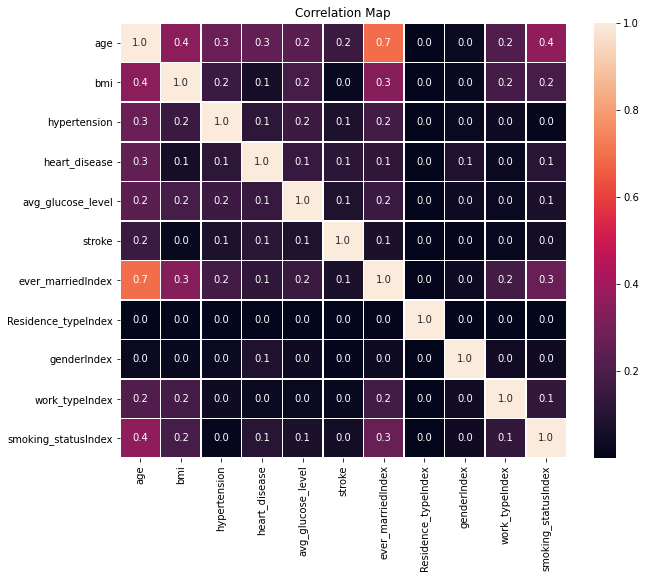

In [13]:
f,ax=plt.subplots(figsize = (10,8))
sns.heatmap(results,annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')




Upsampling the stroke data to the same size as the no stroke data

https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253

In [14]:
# code block 1
from pyspark.sql.functions  import col, explode, array, lit

no_stroke = ohc_traindf.filter(col("stroke") == 0)
stroke = ohc_traindf.filter(col("stroke") == 1)

ratio = int(no_stroke.count()/stroke.count())
print("complete length: {}, no stroke: {}, stroke: {}, ratio: {}".format(ohc_traindf.count(), no_stroke.count(), stroke.count(), ratio))

complete length: 43400, no stroke: 42617, stroke: 783, ratio: 54


In [15]:
a = range(ratio)# duplicate the minority rows
oversampled_df = stroke.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
combined_df = no_stroke.unionAll(oversampled_df)

print("upsampled length: {}".format(combined_df.count()))

upsampled length: 84899


equal dataset: combined_df

unequal dataset: ohc_traindf



Visualizing correlations between variables


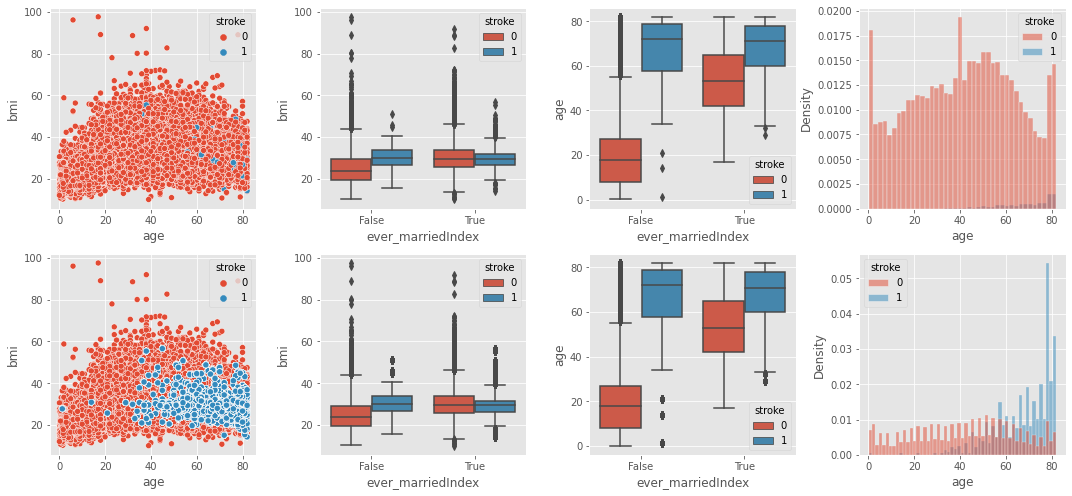

In [16]:
%matplotlib inline
plt.style.use("ggplot")

ohc_pandas = ohc_traindf.toPandas()
combined_pandas = combined_df.toPandas()

ohc_pandas["ever_marriedIndex"] = ~ohc_pandas["ever_marriedIndex"].astype("bool")
combined_pandas["ever_marriedIndex"] = ~combined_pandas["ever_marriedIndex"].astype("bool")

fig, axs = plt.subplots(figsize=(15, 7), ncols=4, nrows =2)
sns.scatterplot(x = "age", y = "bmi", hue = "stroke", data = ohc_pandas, ax = axs[0,0])
sns.boxplot(x = "ever_marriedIndex", y = "bmi", hue = "stroke", data = ohc_pandas, ax = axs[0,1])
sns.boxplot(x = "ever_marriedIndex", y = "age", hue = "stroke", data = ohc_pandas, ax = axs[0,2])
sns.histplot(x = "age", hue = "stroke", data = ohc_pandas, ax = axs[0,3], stat = "density")

sns.scatterplot(x = "age", y = "bmi", hue = "stroke", data = combined_pandas, ax = axs[1,0])
sns.boxplot(x = "ever_marriedIndex", y = "bmi", hue = "stroke", data = combined_pandas, ax = axs[1,1])
sns.boxplot(x = "ever_marriedIndex", y = "age", hue = "stroke", data = combined_pandas, ax = axs[1,2])
sns.histplot(x = "age", hue = "stroke", data = combined_pandas, ax = axs[1,3], stat = "density")

fig.tight_layout()

summary statistics of the upsampled dataset

In [17]:
combined_df.show(5)
ohc_traindf.show(5)

+-----+----+------------+-------------+-----------------+------+----+-----------+--------------+-----------------+-------------------+-------------------+-------------+-------------+-----------------+
|   id| age|hypertension|heart_disease|avg_glucose_level|stroke| bmi|genderIndex|work_typeIndex|ever_marriedIndex|Residence_typeIndex|smoking_statusIndex|    genderCat| work_typeCat|smoking_statusCat|
+-----+----+------------+-------------+-----------------+------+----+-----------+--------------+-----------------+-------------------+-------------------+-------------+-------------+-----------------+
|30669| 3.0|           0|            0|            95.12|     0|18.0|        1.0|           2.0|              1.0|                1.0|                0.0|(2,[1],[1.0])|(4,[2],[1.0])|    (2,[0],[1.0])|
|30468|58.0|           1|            0|            87.96|     0|39.2|        1.0|           0.0|              0.0|                0.0|                0.0|(2,[1],[1.0])|(4,[0],[1.0])|    (2,[0],[1.

In [18]:
ret2 = combined_df.describe()
ret2.show()

+-------+------------------+-----------------+-------------------+-------------------+------------------+-------------------+-----------------+-------------------+------------------+-------------------+-------------------+-------------------+
|summary|                id|              age|       hypertension|      heart_disease| avg_glucose_level|             stroke|              bmi|        genderIndex|    work_typeIndex|  ever_marriedIndex|Residence_typeIndex|smoking_statusIndex|
+-------+------------------+-----------------+-------------------+-------------------+------------------+-------------------+-----------------+-------------------+------------------+-------------------+-------------------+-------------------+
|  count|             84899|            84899|              84899|              84899|             84899|              84899|            84899|              84899|             84899|              84899|              84899|              84899|
|   mean| 36552.30927337189|

# Task 2

In [19]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['age','hypertension','heart_disease','avg_glucose_level','bmi',"genderCat", "work_typeCat", "ever_marriedIndex", "Residence_typeIndex", "smoking_statusCat"],outputCol='features')

In [90]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline

rf = RandomForestClassifier(labelCol='stroke',featuresCol='features')
# rf.setThresholds([0.0,0.5])
lr = LogisticRegression(labelCol="stroke",featuresCol="features",standardization=True,threshold=0.5)

rf_pipeline = Pipeline(stages=[assembler, rf])
lr_pipeline = Pipeline(stages=[assembler, lr])

In [34]:
ohc_traindf.groupBy('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  783|
|     0|42617|
+------+-----+



In [65]:
# splitting training and validation data
train_data,val_data = ohc_traindf.randomSplit([0.7,0.3])

# training dtc pipeline with data
rf_model = rf_pipeline.fit(train_data)

In [36]:
# making prediction on model with validation data
rf_predictions = rf_model.transform(val_data)

# Select example rows to display.
rf_predictions.select("prediction","probability", "stroke", "features").show(5)

+----------+--------------------+------+--------------------+
|prediction|         probability|stroke|            features|
+----------+--------------------+------+--------------------+
|       0.0|[0.98640158008448...|     0|(15,[0,3,4,5,7,11...|
|       0.0|[0.97769163055330...|     0|(15,[0,3,4,5,7,13...|
|       0.0|[0.97468325143329...|     0|(15,[0,3,4,5,7],[...|
|       0.0|[0.98422905065741...|     0|(15,[0,3,4,5,7,13...|
|       0.0|[0.98640158008448...|     0|(15,[0,3,4,5,7,11...|
+----------+--------------------+------+--------------------+
only showing top 5 rows



In [37]:
# training lr pipeline with data
lr_model = lr_pipeline.fit(train_data)

In [38]:
# making prediction on model with validation data
lr_predictions = lr_model.transform(val_data)

# Select example rows to display.
lr_predictions.select("prediction","probability", "stroke", "features").show(5)

+----------+--------------------+------+--------------------+
|prediction|         probability|stroke|            features|
+----------+--------------------+------+--------------------+
|       0.0|[0.99906415722012...|     0|(15,[0,3,4,5,7,11...|
|       0.0|[0.99137232938871...|     0|(15,[0,3,4,5,7,13...|
|       0.0|[0.93382910324069...|     0|(15,[0,3,4,5,7],[...|
|       0.0|[0.99757607260106...|     0|(15,[0,3,4,5,7,13...|
|       0.0|[0.99762720500113...|     0|(15,[0,3,4,5,7,11...|
+----------+--------------------+------+--------------------+
only showing top 5 rows



In [39]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
def evaluate(predictions):
  roc_evaluator = BinaryClassificationEvaluator(labelCol="stroke", rawPredictionCol="rawPrediction", metricName='areaUnderROC')
  evaluator = MulticlassClassificationEvaluator(labelCol="stroke", probabilityCol="probability", metricName='rmse')
  ll = evaluator.setMetricName("logLoss").evaluate(predictions)
  acc = evaluator.setMetricName("accuracy").evaluate(predictions)
  prec = evaluator.setMetricName("precisionByLabel").evaluate(predictions)
  rec = evaluator.setMetricName("recallByLabel").evaluate(predictions)
  fpr = evaluator.setMetricName("falsePositiveRateByLabel").evaluate(predictions)
  tpr = evaluator.setMetricName("truePositiveRateByLabel").evaluate(predictions)
  roc_auc = roc_evaluator.evaluate(predictions)
  
  print('accuracy: {0:2.2f}'.format(acc))
  print('precision: {0:2.2f}'.format(prec))
  print('recall: {0:2.2f}'.format(rec))
  print('true positive rate: {0:2.2f}'.format(tpr))
  print('false positive rate: {0:2.2f}'.format(fpr))
  print('logloss: {0:2.2f}'.format(ll))
  print('roc_auc: {0:2.2f}'.format(roc_auc))
  tn = predictions.filter((col("prediction") == 1) & (col("stroke") == 1)).count()
  fn = predictions.filter((col("prediction") == 1) & (col("stroke") == 0)).count()
  tp = predictions.filter((col("prediction") == 0) & (col("stroke") == 0)).count()
  fp = predictions.filter((col("prediction") == 0) & (col("stroke") == 1)).count()
  print('Confusion matrix:\n[tp {0:05.0f}, fp {1:05.0f}]\n[fn {2:05.0f}, tn {3:05.0f}]'.format(tp,fp,fn,tn))
  print("\n\n")
  return (acc,prec,rec,tpr,fpr,ll,roc_auc)


The Evaluation of the prediction shows, that all real strokes are predicted as no stroke and therefore, the false positive rate is 1.00. The predictive power of this algorithm is negligible.

In [40]:

# Select (prediction, true label) and compute test error

print("Random Forest model")
evaluate(rf_predictions)
print("Logistic Regression model")
evaluate(lr_predictions)

Random Forest model
accuracy: 0.98
precision: 0.98
recall: 1.00
true positive rate: 1.00
false positive rate: 1.00
logloss: 0.08
roc_auc: 0.82
Confusion matrix:
[tp 12771, fp 00236]
[fn 00000, tn 00000]



Logistic Regression model
accuracy: 0.98
precision: 0.98
recall: 1.00
true positive rate: 1.00
false positive rate: 1.00
logloss: 0.08
roc_auc: 0.84
Confusion matrix:
[tp 12771, fp 00236]
[fn 00000, tn 00000]





(0.9818559237333744,
 0.9818559237333744,
 1.0,
 1.0,
 1.0,
 0.0799778056092277,
 0.8378519792591568)

Now using the resampled dataset

In [41]:
combined_df.groupBy('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|42282|
|     0|42617|
+------+-----+



In [91]:
# splitting training and validation data
train_data,val_data = combined_df.randomSplit([0.7,0.3])

# training dtc pipeline with data
rf_model = rf_pipeline.fit(train_data)

In [93]:
# making prediction on model with validation data
rf_predictions = rf_model.transform(val_data)

# Select example rows to display.
rf_predictions.select("prediction","probability", "stroke", "features").show(5)

+----------+--------------------+------+--------------------+
|prediction|         probability|stroke|            features|
+----------+--------------------+------+--------------------+
|       0.0|[0.57516263025800...|     0|(15,[0,3,4,5,7,13...|
|       0.0|[0.74125708902457...|     0|(15,[0,3,4,6,7,12...|
|       1.0|[0.43512405724556...|     0|(15,[0,3,4,6,10,1...|
|       1.0|[0.30377680386920...|     0|(15,[0,3,4,6,7],[...|
|       0.0|[0.86107287546204...|     0|(15,[0,3,4,5,7,11...|
+----------+--------------------+------+--------------------+
only showing top 5 rows



In [94]:
# training lr pipeline with data
lr_model = lr_pipeline.fit(train_data)

In [95]:
# making prediction on model with validation data
lr_predictions = lr_model.transform(val_data)

# Select example rows to display.
lr_predictions.select("prediction","probability", "stroke", "features").show(5)

+----------+--------------------+------+--------------------+
|prediction|         probability|stroke|            features|
+----------+--------------------+------+--------------------+
|       0.0|[0.71069129205599...|     0|(15,[0,3,4,5,7,13...|
|       0.0|[0.78124100111973...|     0|(15,[0,3,4,6,7,12...|
|       0.0|[0.58327976668905...|     0|(15,[0,3,4,6,10,1...|
|       1.0|[0.17038880208057...|     0|(15,[0,3,4,6,7],[...|
|       0.0|[0.86362168222312...|     0|(15,[0,3,4,5,7,11...|
+----------+--------------------+------+--------------------+
only showing top 5 rows



In [96]:
print("Random Forest model")
evaluate(rf_predictions)
print("Logistic Regression model")
evaluate(lr_predictions)

Random Forest model
accuracy: 0.78
precision: 0.84
recall: 0.70
true positive rate: 0.70
false positive rate: 0.13
logloss: 0.48
roc_auc: 0.86
Confusion matrix:
[tp 08915, fp 01728]
[fn 03877, tn 11091]



Logistic Regression model
accuracy: 0.78
precision: 0.80
recall: 0.74
true positive rate: 0.74
false positive rate: 0.18
logloss: 0.47
roc_auc: 0.85
Confusion matrix:
[tp 09436, fp 02303]
[fn 03356, tn 10516]





(0.7790402561399399,
 0.8038163387000596,
 0.7376485303314572,
 0.7376485303314572,
 0.179655199313519,
 0.4703588827366521,
 0.8501608311732)